In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

file_path = 'limelight-psms-searches-6036-6040-6043-6047-6051-6067-6064-6079-6083-6086-6090-2024-05-21.txt'


In [3]:
def load_peptide_search_results(file_path):
    """
    Load tab-delimited peptide search results from a file.

    Args:
        file_path (str): The path to the tab-delimited file containing the peptide search results.

    Returns:
        pd.DataFrame: A DataFrame containing the peptide search results, with the first row as the header.
    """
    try:
        # Read the tab-delimited file using pandas
        data = pd.read_csv(file_path, sep='\t')
        
        return data
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred while loading the file: {str(e)}")
        return None

In [6]:
peptide_data = load_peptide_search_results(file_path)

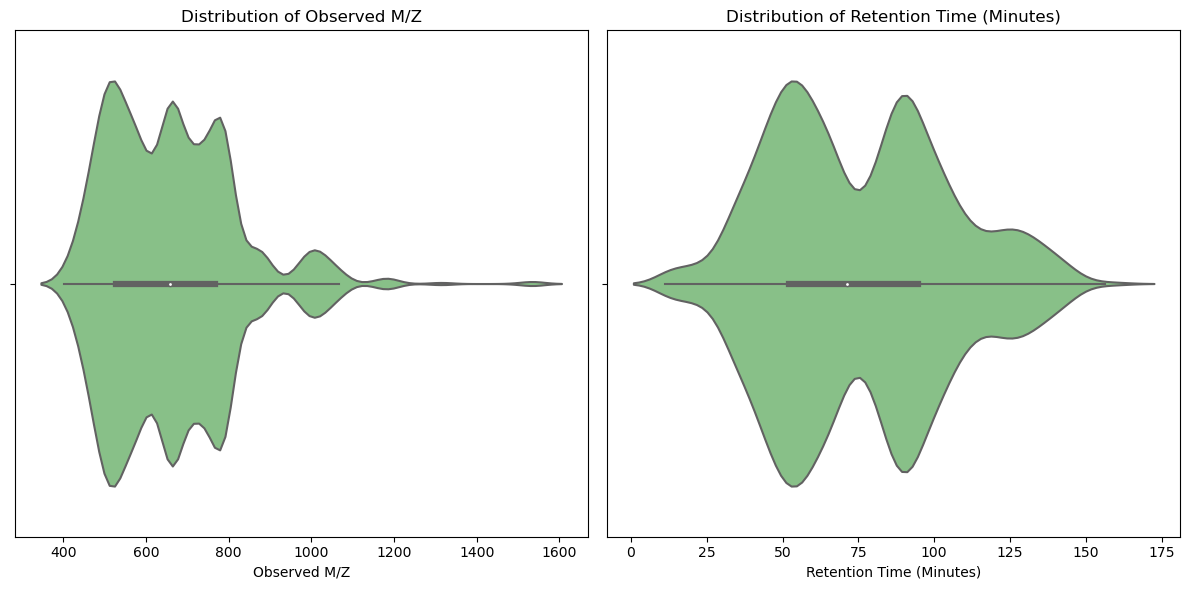

In [9]:
if peptide_data is not None:
    # Set the color palette to a pastel color scheme
    sns.set_palette('Accent')

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Create a violin plot for the "OBSERVED M/Z" column
    sns.violinplot(x=peptide_data['OBSERVED M/Z'], ax=ax1)
    ax1.set_title('Distribution of Observed M/Z')
    ax1.set_xlabel('Observed M/Z')

    # Create a violin plot for the "RETENTION TIME (MINUTES)" column
    sns.violinplot(x=peptide_data['RETENTION TIME (MINUTES)'], ax=ax2)
    ax2.set_title('Distribution of Retention Time (Minutes)')
    ax2.set_xlabel('Retention Time (Minutes)')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the plots
    plt.show()

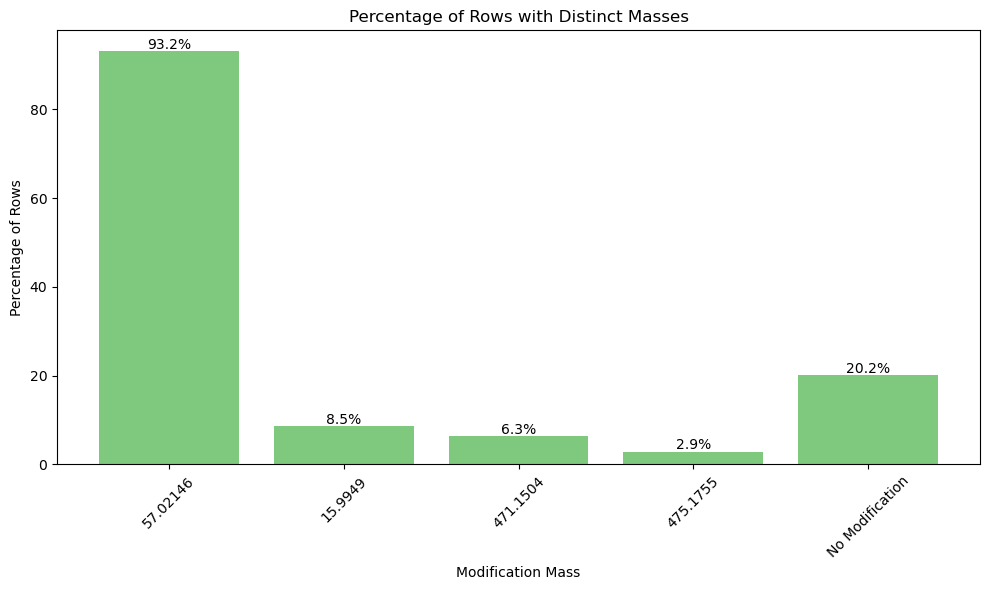

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Extract the distinct masses from the "MODS" column
masses = peptide_data['MODS'].str.extractall(r'(\d+\.\d+)').unstack()
masses = masses.apply(pd.Series).stack().reset_index(drop=True)

# Count the occurrences of each distinct mass
mass_counts = masses.value_counts()

# Calculate the percentage of rows that have each mass
mass_percentages = (mass_counts / len(peptide_data)) * 100

# Calculate the percentage of rows with no modifications
no_mod_count = peptide_data['MODS'].apply(lambda x: not bool(re.search(r'\d+\.\d+', str(x)))).sum()
no_mod_percentage = (no_mod_count / len(peptide_data)) * 100

# Combine the mass percentages and no modification percentage
percentages = pd.concat([mass_percentages, pd.Series([no_mod_percentage], index=['No Modification'])])

# Format the labels to remove parentheses, single quotes, and comma
labels = [re.sub(r"[(')\,]", '', str(label)) for label in percentages.index]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, percentages)
plt.xlabel('Modification Mass')
plt.ylabel('Percentage of Rows')
plt.title('Percentage of Rows with Distinct Masses')
plt.xticks(rotation=45)

# Add percentage labels on top of each bar
for i, v in enumerate(percentages):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center')

# Display the plot
plt.tight_layout()
plt.show()

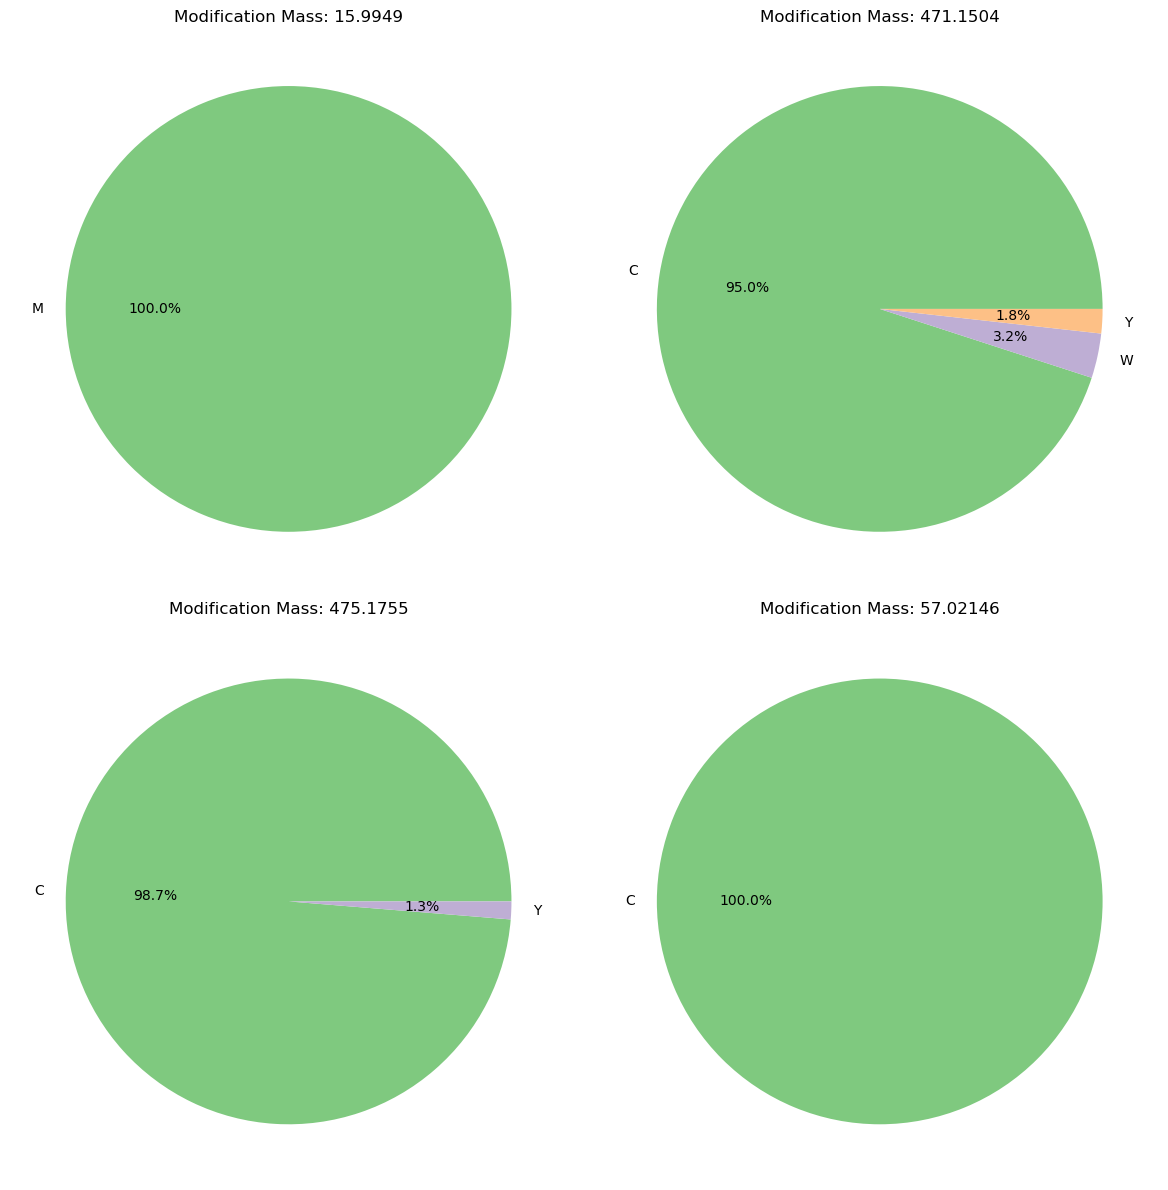

In [19]:
# Extract the distinct masses and positions from the "MODS" column
mods_data = peptide_data['MODS'].str.extractall(r'(\d+)\((\d+\.\d+)\)').reset_index(level=1, drop=True)
mods_data.columns = ['Position', 'Mass']
mods_data['Position'] = mods_data['Position'].astype(int)

# Merge the modifications data with the peptide sequences
merged_data = mods_data.merge(peptide_data['PEPTIDE'], left_index=True, right_index=True)

# Function to extract the amino acid at a given position in the peptide sequence
def get_amino_acid(row):
    peptide = row['PEPTIDE']
    position = row['Position'] - 1
    if 0 <= position < len(peptide):
        return peptide[position]
    else:
        return 'Unknown'

# Apply the function to extract the amino acid for each modification
merged_data['Amino Acid'] = merged_data.apply(get_amino_acid, axis=1)

# Group the data by modification mass and amino acid, and count the occurrences
grouped_data = merged_data.groupby(['Mass', 'Amino Acid']).size().reset_index(name='Count')

# Get the list of distinct modification masses
mod_masses = grouped_data['Mass'].unique()

# Create subplots for each modification mass
num_masses = len(mod_masses)
num_cols = 2
num_rows = (num_masses + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))

for i, mass in enumerate(mod_masses):
    # Filter the data for the current modification mass
    mass_data = grouped_data[grouped_data['Mass'] == mass].copy()
    
    # Calculate the fraction of occurrences for each amino acid
    mass_data.loc[:, 'Fraction'] = mass_data['Count'] / mass_data['Count'].sum()
    
    # Create a pie chart in the corresponding subplot
    ax = axes[i // num_cols, i % num_cols]
    ax.pie(mass_data['Fraction'], labels=mass_data['Amino Acid'], autopct='%1.1f%%')
    ax.set_title(f'Modification Mass: {mass}')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [22]:
# Extract the distinct masses and positions from the "MODS" column
mods_data = peptide_data['MODS'].str.extractall(r'(\d+)\((\d+\.\d+)\)').reset_index(level=1, drop=True)
mods_data.columns = ['Position', 'Mass']
mods_data['Mass'] = mods_data['Mass'].astype(float).round().astype(int)

# Count rows with 471 modification mass
count_471 = mods_data[mods_data['Mass'] == 471].groupby(level=0).size().sum()

# Count rows with 475 modification mass
count_475 = mods_data[mods_data['Mass'] == 475].groupby(level=0).size().sum()

# Count rows with both 471 and 475 modification masses
mods_data['Has_471'] = mods_data['Mass'] == 471
mods_data['Has_475'] = mods_data['Mass'] == 475
count_both = (mods_data.groupby(level=0)
                       .agg({'Has_471': 'any', 'Has_475': 'any'})
                       .all(axis=1)
                       .sum())

# Print the counts
print(f"Number of rows with 471 modification mass: {count_471}")
print(f"Number of rows with 475 modification mass: {count_475}")
print(f"Number of rows with both 471 and 475 modification masses: {count_both}")

Number of rows with 471 modification mass: 340
Number of rows with 475 modification mass: 155
Number of rows with both 471 and 475 modification masses: 0


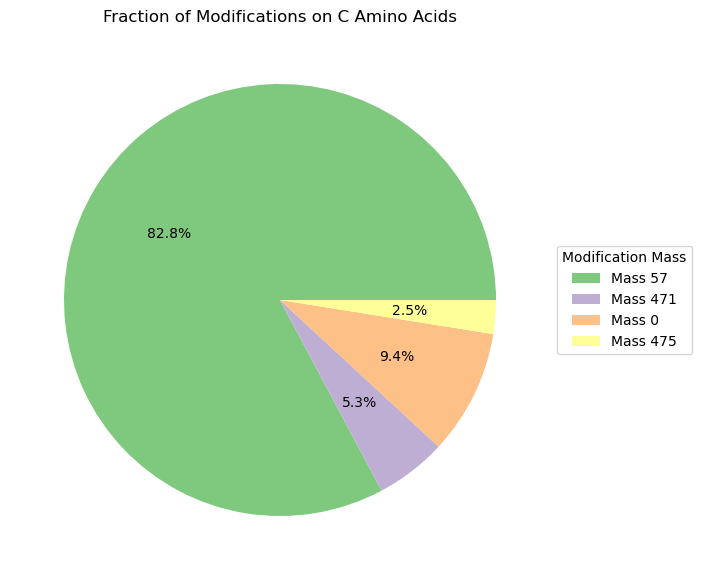

In [29]:
# Convert the 'MODS' column to a string
peptide_data['MODS'] = peptide_data['MODS'].astype(str)

# Initialize a dictionary to store the modification mass counts
mod_mass_counts = {}

# Iterate over each row in the DataFrame
for _, row in peptide_data.iterrows():
    peptide = row['PEPTIDE']
    mods = row['MODS']
    
    # Extract the modification positions and masses from the "MODS" column
    mod_positions = [int(pos) for pos, _ in re.findall(r'(\d+)\((\d+\.\d+)\)', mods)]
    mod_masses = [float(mass) for _, mass in re.findall(r'(\d+)\((\d+\.\d+)\)', mods)]
    
    # Iterate over each amino acid in the peptide sequence
    for i, aa in enumerate(peptide, start=1):
        if aa == 'C':
            if i in mod_positions:
                # C amino acid has a modification
                mod_mass = int(mod_masses[mod_positions.index(i)])
                mod_mass_counts[mod_mass] = mod_mass_counts.get(mod_mass, 0) + 1
            else:
                # C amino acid has no modification
                mod_mass_counts[0] = mod_mass_counts.get(0, 0) + 1

# Calculate the total count of C amino acids
total_c_count = sum(mod_mass_counts.values())

# Calculate the fraction of C amino acids with each modification mass
mod_mass_fractions = {mass: count / total_c_count for mass, count in mod_mass_counts.items()}

# Create a pie chart
plt.figure(figsize=(8, 8))
_, _, autotexts = plt.pie(mod_mass_fractions.values(), labels=None, autopct='%1.1f%%')
plt.title('Fraction of Modifications on C Amino Acids')

# Create a legend outside the pie chart
labels = [f"Mass {mass}" for mass in mod_mass_fractions.keys()]
plt.legend(labels, title="Modification Mass", loc="center left", bbox_to_anchor=(1, 0.5))

# Adjust the spacing between the pie chart and the legend
plt.subplots_adjust(right=0.8)

# Display the plot
plt.show()

In [43]:
def add_mod_masses(row):
    peptide = row['PEPTIDE']
    mods = row['MODS']
    
    if not mods:
        return peptide
    
    mod_positions = re.findall(r'(\d+)\((\d+\.\d+)\)', mods)
    mod_positions = [(int(pos), mass) for pos, mass in mod_positions]
    
    mod_peptide = ''
    for i, aa in enumerate(peptide, start=1):
        mod_peptide += aa
        for pos, mass in mod_positions:
            if pos == i:
                mod_peptide += f'[{mass}]'
    
    return mod_peptide

peptide_data['mod_peptide'] = peptide_data.apply(add_mod_masses, axis=1)

print(peptide_data[['PEPTIDE', 'MODS', 'mod_peptide']].head(10))

           PEPTIDE         MODS                mod_peptide
0  LSLLEVGCGTGANFK  8(57.02146)  LSLLEVGC[57.02146]GTGANFK
1  LSLLEVGCGTGANFK  8(57.02146)  LSLLEVGC[57.02146]GTGANFK
2  LSLLEVGCGTGANFK  8(57.02146)  LSLLEVGC[57.02146]GTGANFK
3  LSLLEVGCGTGANFK  8(57.02146)  LSLLEVGC[57.02146]GTGANFK
4  LSLLEVGCGTGANFK  8(57.02146)  LSLLEVGC[57.02146]GTGANFK
5  LSLLEVGCGTGANFK  8(57.02146)  LSLLEVGC[57.02146]GTGANFK
6  LSLLEVGCGTGANFK  8(57.02146)  LSLLEVGC[57.02146]GTGANFK
7  LSLLEVGCGTGANFK  8(57.02146)  LSLLEVGC[57.02146]GTGANFK
8  LSLLEVGCGTGANFK  8(57.02146)  LSLLEVGC[57.02146]GTGANFK
9  LSLLEVGCGTGANFK  8(57.02146)  LSLLEVGC[57.02146]GTGANFK


In [47]:
def add_mod_masses(row):
    peptide = row['PEPTIDE']
    mods = row['MODS']
    
    if not mods:
        return peptide
    
    mod_positions = re.findall(r'(\d+)\((\d+\.\d+)\)', mods)
    mod_positions = [(int(pos), mass) for pos, mass in mod_positions]
    
    mod_peptide = ''
    for i, aa in enumerate(peptide, start=1):
        mod_peptide += aa
        for pos, mass in mod_positions:
            if pos == i:
                mod_peptide += f'[{mass}]'
    
    return mod_peptide

def replace_mod_masses(mod_peptide):
    return re.sub(r'\[(?:471\.1504|475\.1755)\]', '*', mod_peptide)

peptide_data['mod_peptide'] = peptide_data.apply(add_mod_masses, axis=1)
peptide_data['star_mod_peptide'] = peptide_data['mod_peptide'].apply(replace_mod_masses)

print(peptide_data[peptide_data['MODS'].str.contains('471\.1504|475\.1755')][['mod_peptide', 'star_mod_peptide']].head(5))

                mod_peptide star_mod_peptide
199  GLC[471.1504]AIAQAESLR    GLC*AIAQAESLR
200  GLC[471.1504]AIAQAESLR    GLC*AIAQAESLR
201  GLC[471.1504]AIAQAESLR    GLC*AIAQAESLR
278   GC[471.1504]TATLGNFAK     GC*TATLGNFAK
279   GC[471.1504]TATLGNFAK     GC*TATLGNFAK


In [89]:
# Create a dictionary to store the collected rows
collected_rows = {}

# Iterate over each row in the DataFrame
for _, row in peptide_data.iterrows():
    star_mod_peptide = row['star_mod_peptide']
    mods = row['MODS']
    
    if '471.1504' in mods or '475.1755' in mods:
        if star_mod_peptide not in collected_rows:
            collected_rows[star_mod_peptide] = {'471.1504': [], '475.1755': []}
        
        if '471.1504' in mods:
            collected_rows[star_mod_peptide]['471.1504'].append(row)
        
        if '475.1755' in mods:
            collected_rows[star_mod_peptide]['475.1755'].append(row)

# check that we have the expected number of peptides containing either 471 or 475
filtered_df = peptide_data[peptide_data['mod_peptide'].str.contains('471.1504|475.1755')]
num_distinct_values = filtered_df['mod_peptide'].nunique()
print(num_distinct_values)

# how many entries our in our dict when 471 and 475 are subbed with a *
len(collected_rows)

127


95

In [90]:
# Iterate over each star_mod_peptide in collected_rows
for star_mod_peptide, mod_dict in collected_rows.items():
    # Find the position of the * in the star_mod_peptide
    star_pos = star_mod_peptide.find('*')
    
    if star_pos != -1:
        if star_pos == 0 or star_mod_peptide[star_pos - 1] == 'C':
            # If the * comes after a C or is at the beginning, find rows with [57.02146] at that position
            nomod_peptide = star_mod_peptide[:star_pos] + '[57.02146]' + star_mod_peptide[star_pos + 1:]
            nomod_rows = peptide_data[peptide_data['mod_peptide'] == nomod_peptide]
        else:
            # If the * does not come after a C, find rows with no modification at that position
            nomod_peptide = star_mod_peptide.replace('*', '')
            nomod_rows = peptide_data[peptide_data['mod_peptide'] == nomod_peptide]
        
        # Initialize the "nomod" key as an empty list if it doesn't exist
        if 'nomod' not in mod_dict:
            mod_dict['nomod'] = []
        
        # Append each row from nomod_rows to the "nomod" list as a Series
        for _, row in nomod_rows.iterrows():
            mod_dict['nomod'].append(row)

# check that we have the expected number of peptides containing either 471 or 475
filtered_df = peptide_data[peptide_data['mod_peptide'].str.contains('471.1504|475.1755')]
num_distinct_values = filtered_df['mod_peptide'].nunique()
print(num_distinct_values)

# how many entries our in our dict when 471 and 475 are subbed with a *
len(collected_rows)

127


95

In [91]:
# Print the collected rows
for star_mod_peptide, mod_dict in collected_rows.items():
    print(f"star_mod_peptide: {star_mod_peptide}")
    print("Rows with 471.1504:")
    for row in mod_dict['471.1504']:
        print(row[['PEPTIDE', 'MODS', 'mod_peptide', 'star_mod_peptide']])
    print("Rows with 475.1755:")
    for row in mod_dict['475.1755']:
        print(row[['PEPTIDE', 'MODS', 'mod_peptide', 'star_mod_peptide']])
    print("Rows with nomod:")
    for row in mod_dict['nomod']:
        print(row[['PEPTIDE', 'MODS', 'mod_peptide', 'star_mod_peptide']])
    print()

star_mod_peptide: GLC*AIAQAESLR
Rows with 471.1504:
PEPTIDE                       GLCAIAQAESLR
MODS                           3(471.1504)
mod_peptide         GLC[471.1504]AIAQAESLR
star_mod_peptide             GLC*AIAQAESLR
Name: 199, dtype: object
PEPTIDE                       GLCAIAQAESLR
MODS                           3(471.1504)
mod_peptide         GLC[471.1504]AIAQAESLR
star_mod_peptide             GLC*AIAQAESLR
Name: 200, dtype: object
PEPTIDE                       GLCAIAQAESLR
MODS                           3(471.1504)
mod_peptide         GLC[471.1504]AIAQAESLR
star_mod_peptide             GLC*AIAQAESLR
Name: 201, dtype: object
PEPTIDE                       GLCAIAQAESLR
MODS                           3(471.1504)
mod_peptide         GLC[471.1504]AIAQAESLR
star_mod_peptide             GLC*AIAQAESLR
Name: 488, dtype: object
PEPTIDE                       GLCAIAQAESLR
MODS                           3(471.1504)
mod_peptide         GLC[471.1504]AIAQAESLR
star_mod_peptide             GL

In [92]:
print(type(collected_rows['GLC*AIAQAESLR']['471.1504'])[0])
print(type(collected_rows['GLC*AIAQAESLR']['475.1755'][0]))
print(type(collected_rows['GLC*AIAQAESLR']['nomod'][0]))

list[0]
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
